In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely
import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tobler.model import glm
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation, you need to find the folder where rasterio is storing the 'Proj.db' file
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

gdf = gpd.read_file('NJ City Shapefiles/cb_2018_34_cousub_500k.shp')
# Convert county FIPS codes to str
gdf['COUSUBNS'] = gdf['COUSUBNS'].astype(str)

In [2]:
gdf.shape

(565, 11)

In [3]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [4]:
gdf.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
AFFGEOID      object
GEOID         object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
dtype: object

In [5]:
# Specify columns of interest
gdf = gdf[['COUSUBFP','NAME','geometry']]
gdf.head()

,COUSUBFP,NAME,geometry
0,63850,Robbinsville,"POLYGON ((-74.64994 40.24176, -74.62104 40.249..."
1,67350,Shrewsbury,"POLYGON ((-74.07491 40.33727, -74.06909 40.337..."
2,34530,Island Heights,"POLYGON ((-74.15572 39.94746, -74.15372 39.947..."
3,83050,Wyckoff,"POLYGON ((-74.19029 40.99239, -74.18882 41.004..."
4,64410,Roosevelt,"POLYGON ((-74.48993 40.21676, -74.48472 40.220..."


In [6]:
FIPS = pd.read_csv('NJ_FIPS_codes.csv', header=None)

In [7]:
FIPS.head()

,0,1,2,3,4,5,6
0,NJ,34,1,Atlantic County,0,County subdivisions not defined,F
1,NJ,34,1,Atlantic County,100,Absecon city,F
2,NJ,34,1,Atlantic County,2080,Atlantic City city,F
3,NJ,34,1,Atlantic County,7810,Brigantine city,F
4,NJ,34,1,Atlantic County,8680,Buena borough,F


In [8]:
# Drop County subdivisions not defined
FIPS = FIPS[FIPS[5] != 'County subdivisions not defined']

# Select Columns of interest
FIPS = FIPS[[3,4,5]]

FIPS.head()

,3,4,5
1,Atlantic County,100,Absecon city
2,Atlantic County,2080,Atlantic City city
3,Atlantic County,7810,Brigantine city
4,Atlantic County,8680,Buena borough
5,Atlantic County,8710,Buena Vista township


In [9]:
FIPS.shape

(566, 3)

In [10]:
FIPS.dtypes

3    object
4     int64
5    object
dtype: object

In [11]:
# Rename columns
FIPS = FIPS.rename(columns={3:'County', 4: 'COUSUBFP', 5: 'City'})

# Convert COUSUBNS to string and pad with zeroes

FIPS['COUSUBFP'] = FIPS['COUSUBFP'].astype(str)

FIPS['COUSUBFP'] = FIPS['COUSUBFP'].apply(lambda x: x.zfill(5)).astype(str)

# Make City in Title Format

# Remove Repeated Word 'city' from City Column
FIPS['City'] = FIPS['City'].str.split(' city',expand=False)
FIPS['City'] = FIPS['City'].apply(lambda x: x[0])

FIPS['City'] = FIPS['City'].str.title()

FIPS.head()

,County,COUSUBFP,City
1,Atlantic County,00100,Absecon
2,Atlantic County,02080,Atlantic City
3,Atlantic County,07810,Brigantine
4,Atlantic County,08680,Buena Borough
5,Atlantic County,08710,Buena Vista Township


In [12]:
merge = FIPS.merge(gdf,how='inner',on='COUSUBFP')

# Drop NAME and COUSUBFP columns
merge.drop(['NAME','COUSUBFP'],axis=1,inplace=True)

# Add State Column
merge['State'] = 'New Jersey'

# Rearrange Columns

merge = merge[['State','County','City','geometry']]

merge.head()

,State,County,City,geometry
0,New Jersey,Atlantic County,Absecon,"POLYGON ((-74.53138 39.42627, -74.52287 39.435..."
1,New Jersey,Atlantic County,Atlantic City,"POLYGON ((-74.49956 39.35965, -74.49366 39.364..."
2,New Jersey,Atlantic County,Brigantine,"POLYGON ((-74.42199 39.38523, -74.41318 39.389..."
3,New Jersey,Atlantic County,Buena Borough,"POLYGON ((-74.98527 39.51497, -74.95626 39.540..."
4,New Jersey,Atlantic County,Buena Vista Township,"POLYGON ((-74.97183 39.50916, -74.94928 39.508..."


In [13]:
import pymssql

database = "Pushing-P-DB"
table = "dbo.Master_Table"
user = "pushing_p"
password  = "t3stP@ssword"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)


# Query select all rows from SQL table to insert in DataFrame
query = f'SELECT * FROM {table}'
master_table = pd.read_sql(query, conn)
master_table.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude
0,New Jersey,Bergen County,Ramsey Borough,2.3,156058,14915,259,11,11,0,...,159,100,199,4,0,4,0,52,41.062513,-74.135741
1,New Jersey,Monmouth County,Middletown Township,5.6,119013,65168,1821,21,88,191,...,1143,678,1326,225,46,119,0,0,40.392780,-74.099818
2,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,19,34,37,0,0,0,0,16,40.629903,-74.969181
3,New Jersey,Essex County,Maplewood Township,5.4,149568,25129,974,0,74,335,...,354,620,80,821,24,0,0,42,40.729979,-74.271992
4,New Jersey,Bergen County,Ridgefield Borough,6.2,79696,11209,1525,85,145,85,...,684,841,802,2,3,673,0,20,40.834267,-74.008750


In [14]:
# Merge Geodata with Master_table
df = master_table.merge(merge[['City','geometry']],how='inner',on=['City'])

# Convert to Geodataframe
df = gpd.GeoDataFrame(df, geometry=df['geometry'])

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude,geometry,% Uninsured
0,New Jersey,Bergen County,Ramsey Borough,2.3,156058,14915,259,11,11,0,...,199,4,0,4,0,52,41.062513,-74.135741,"POLYGON ((-74.17616 41.05181, -74.17315 41.054...",1.736507
1,New Jersey,Monmouth County,Middletown Township,5.6,119013,65168,1821,21,88,191,...,1326,225,46,119,0,0,40.392780,-74.099818,"MULTIPOLYGON (((-74.02076 40.47522, -74.01838 ...",2.794316
2,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,37,0,0,0,0,16,40.629903,-74.969181,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",1.121456
3,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,37,0,0,0,0,16,40.629903,-74.969181,"POLYGON ((-74.31176 40.69007, -74.30893 40.690...",1.121456
4,New Jersey,Union County,Union Township,5.2,95489,58355,3879,45,339,583,...,1379,1106,0,311,0,835,40.697590,-74.263163,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",6.647245


In [15]:
# Read in Census Tract Shape files
tract = gpd.read_file('NJ Census Tract Shapefiles/cb_2018_34_tract_500k.shp')
tract.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,34,023,004700,1400000US34023004700,34023004700,47,CT,648594,0,"POLYGON ((-74.29005 40.52265, -74.28748 40.521..."
1,34,023,006103,1400000US34023006103,34023006103,61.03,CT,2845215,9920,"POLYGON ((-74.49146 40.45320, -74.48557 40.457..."
2,34,023,006500,1400000US34023006500,34023006500,65,CT,5178980,530,"POLYGON ((-74.42388 40.44648, -74.42045 40.445..."
3,34,029,715902,1400000US34029715902,34029715902,7159.02,CT,3377179,201835,"POLYGON ((-74.19763 40.04472, -74.19664 40.050..."
4,34,029,721000,1400000US34029721000,34029721000,7210,CT,2260503,240040,"POLYGON ((-74.33147 40.02096, -74.32669 40.021..."


In [16]:
tract.shape

(2006, 10)

In [17]:
col_dict = {'NAME':'Census Tract',
'GEO_ID':'AFFGEOID',
'S2701_C01_001E': 'City Population', 
'S2701_C04_001E': 'Uninsured Population', 
'S2701_C04_002E': 'NUI, Under 6 years',
'S2701_C04_003E': 'NUI, 6-18 years',
'S2701_C04_004E': 'NUI, 19 to 25 years',
'S2701_C04_005E': 'NUI, 26 to 34 years',
'S2701_C04_006E': 'NUI, 35 to 44 years',
'S2701_C04_007E': 'NUI, 45 to 54 years',
'S2701_C04_008E': 'NUI, 55 to 64 years',
'S2701_C04_013E': 'NUI, 65 years and older',
'S2701_C04_014E': 'NUI, Men',
'S2701_C04_015E': 'NUI, Women',
'S2701_C04_016E': 'NUI, White',
'S2701_C04_017E': 'NUI, African American',
'S2701_C04_018E': 'NUI, American Indian & Alaska Native Population',
'S2701_C04_019E': 'NUI, Asians',
'S2701_C04_020E': 'NUI, Native Hawaiians & Pacific Islanders Population',
'S2701_C04_021E': 'NUI, Other Races',
}

# Import Tract Healthcare information
tract_h = pd.read_csv('NJ_Uninsured_by_Census_Tract.csv', low_memory=False)

# Drop First Row
tract_h.drop(0,inplace=True)

# Rename columns
tract_h = tract_h.rename(columns = col_dict)

# Select Columns of interest
tract_h = tract_h[['Census Tract','AFFGEOID','City Population','Uninsured Population','NUI, Under 6 years','NUI, 6-18 years', 'NUI, 19 to 25 years',
'NUI, 26 to 34 years', 'NUI, 35 to 44 years','NUI, 45 to 54 years','NUI, 55 to 64 years','NUI, 65 years and older',
'NUI, Men', 'NUI, Women','NUI, White','NUI, African American', 'NUI, American Indian & Alaska Native Population', 
'NUI, Asians', 'NUI, Native Hawaiians & Pacific Islanders Population']]

# Merge based on AFFGEOID column
tract_info = tract_h.merge(tract,how='inner',on='AFFGEOID')

# Convert to Geodataframe
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'])

# Convert columns to appropriate Datatypes
tract_info[['City Population', 'Uninsured Population', 'NUI, Under 6 years', 'NUI, 6-18 years', 'NUI, 19 to 25 years','NUI, 26 to 34 years', 'NUI, 35 to 44 years', 'NUI, 45 to 54 years',
'NUI, 55 to 64 years', 'NUI, 65 years and older', 'NUI, Men', 'NUI, Women','NUI, White','NUI, African American','NUI, American Indian & Alaska Native Population','NUI, Asians',
'NUI, Native Hawaiians & Pacific Islanders Population']] = tract_info[['City Population', 'Uninsured Population', 'NUI, Under 6 years', 'NUI, 6-18 years', 'NUI, 19 to 25 years','NUI, 26 to 34 years', 'NUI, 35 to 44 years', 'NUI, 45 to 54 years',
'NUI, 55 to 64 years', 'NUI, 65 years and older', 'NUI, Men', 'NUI, Women','NUI, White','NUI, African American','NUI, American Indian & Alaska Native Population','NUI, Asians',
'NUI, Native Hawaiians & Pacific Islanders Population']].astype(int)

tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100
tract_info.head()

,Census Tract,AFFGEOID,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years",...,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,LSAD,ALAND,AWATER,geometry,% Uninsured
0,"Census Tract 1, Atlantic County, New Jersey",1400000US34001000100,2157,266,0,14,49,54,93,34,...,34,001,000100,34001000100,1,CT,1704430,466885,"POLYGON ((-74.46816 39.36092, -74.46465 39.360...",12.331943
1,"Census Tract 2, Atlantic County, New Jersey",1400000US34001000200,3510,354,0,0,41,43,194,51,...,34,001,000200,34001000200,2,CT,523378,670249,"POLYGON ((-74.46781 39.34745, -74.46588 39.348...",10.085470
2,"Census Tract 3, Atlantic County, New Jersey",1400000US34001000300,3801,1027,83,81,160,291,172,143,...,34,001,000300,34001000300,3,CT,365553,45436,"POLYGON ((-74.46079 39.35222, -74.45794 39.353...",27.019205
3,"Census Tract 4, Atlantic County, New Jersey",1400000US34001000400,3178,476,0,2,93,152,50,55,...,34,001,000400,34001000400,4,CT,676905,1019528,"POLYGON ((-74.45701 39.35039, -74.45507 39.351...",14.977974
4,"Census Tract 5, Atlantic County, New Jersey",1400000US34001000500,3385,738,21,53,151,240,126,121,...,34,001,000500,34001000500,5,CT,273704,79771,"POLYGON ((-74.45174 39.35901, -74.44999 39.360...",21.802068


In [18]:
tract_info.shape

(1831, 29)

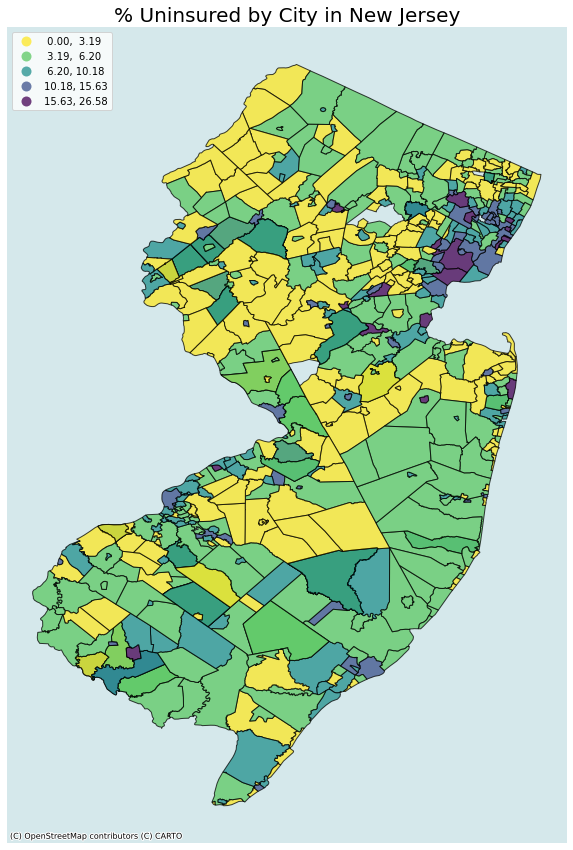

In [19]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

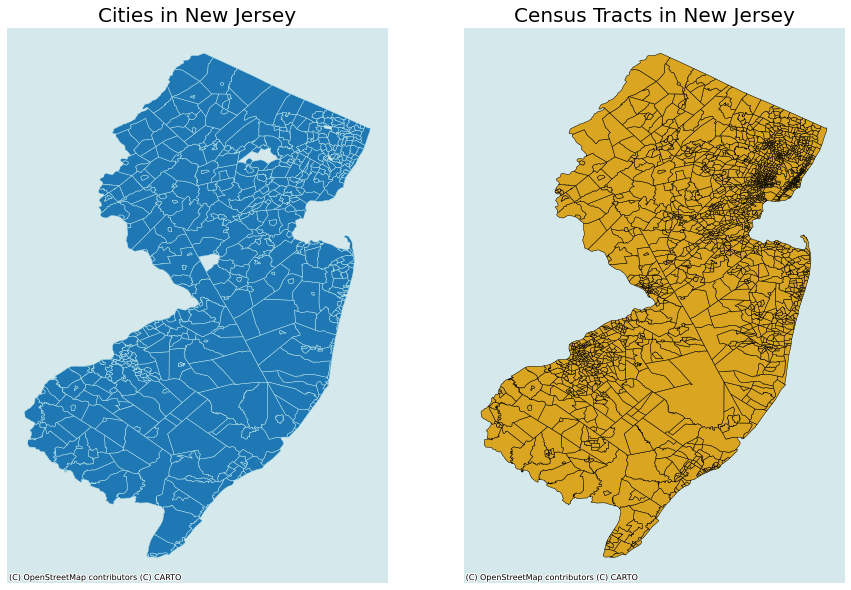

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


In [21]:
# Set df to the same Coordinate System as Tract
df = df.set_crs(tract.crs)

In [22]:
extensive_variables = list(df.drop(['State','County','City','Latitude','Longitude','geometry','% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract, intensive_variables = ['Unemployment Rate (16 & Over)'],extensive_variables=extensive_variables)
results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100

In [23]:
results.head()

,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years",...,"NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Unemployment Rate (16 & Over),geometry,% Uninsured
0,0.312579,2528.061161,2387.120865,473.066734,17.215150,58.830094,80.803904,103.850745,84.396225,81.177132,...,227.762504,317.943766,17.914953,0.839763,2.519290,0.0,93.540316,6.7,"POLYGON ((-74.29005 40.52265, -74.28748 40.521...",19.817460
1,0.502559,8801.247318,3661.861648,200.574963,8.166587,14.089606,12.563980,43.255988,57.166108,31.679178,...,90.819625,59.499419,48.281579,2.153825,38.409881,0.0,45.679041,5.6,"POLYGON ((-74.49146 40.45320, -74.48557 40.457...",5.477404
2,0.544643,10971.253008,4262.144026,166.250046,2.767858,9.017860,16.607147,36.428581,26.339293,26.160721,...,83.928594,68.303590,8.214288,0.000000,66.339304,0.0,19.732148,6.1,"POLYGON ((-74.42388 40.44648, -74.42045 40.445...",3.900620
3,0.369692,2898.499246,5711.362268,335.647647,13.187537,19.091581,54.460665,87.512275,84.643020,50.929275,...,169.948176,212.159330,19.257115,0.000000,4.193526,0.0,94.961302,6.7,"POLYGON ((-74.19763 40.04472, -74.19664 40.050...",5.876840
4,6.062805,68592.815701,2614.829128,223.932637,67.473153,0.000000,10.756590,22.491051,37.159127,62.583794,...,90.942075,172.105433,17.601692,0.000000,24.446794,0.0,0.000000,6.2,"POLYGON ((-74.33147 40.02096, -74.32669 40.021...",8.563949


In [24]:
# Note, some values missing from the table
results.shape

(2006, 23)

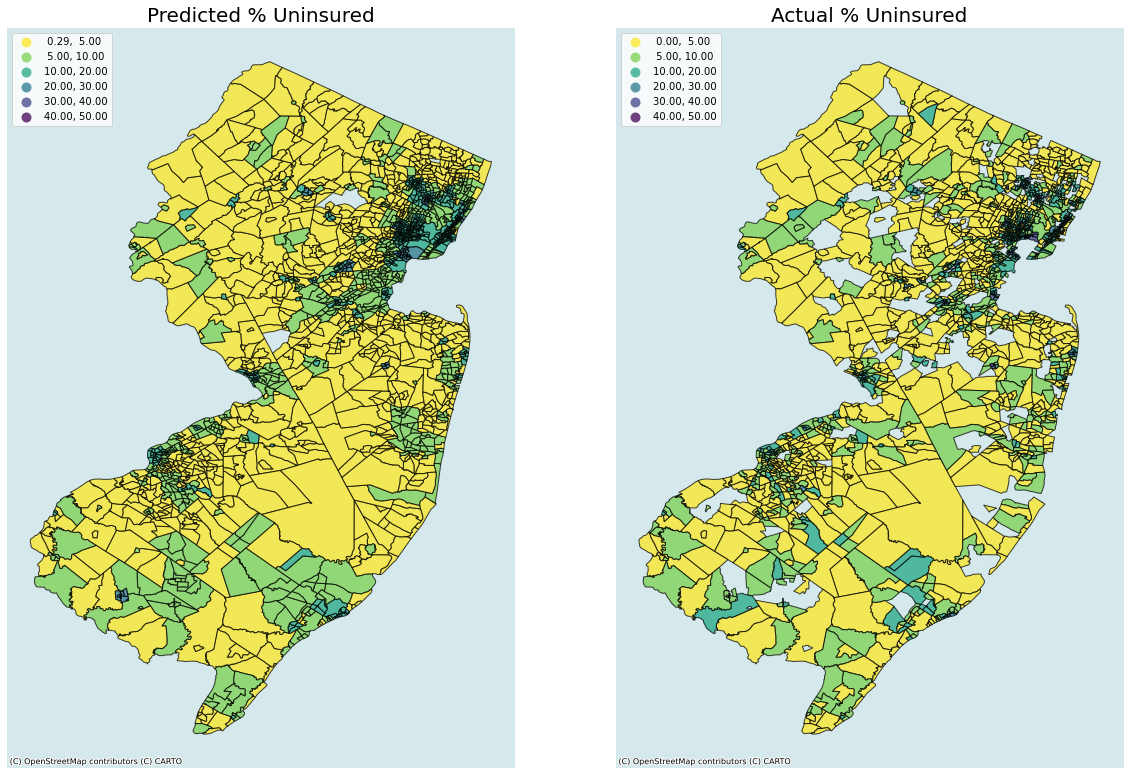

In [25]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');